In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import ticker as mticker
%matplotlib inline
# params = {"text.usetex": True,
#           "font.family": "serif",
#           "font.serif": ["Computer Modern Serif"]}
# plt.rcParams.update(params)


In [4]:
totalECF_demo = pd.read_csv(
    '../../../../CEEPR/DoingTheDirtyWork/Analysis/iraComparison/Temp/ira_counties_ecf.csv',
    index_col=0,
    dtype={'FIPS': str, 'FIPSTATE': str}
    )
for col in totalECF_demo.columns:
    print(col)

FIPS
County
FIPSTATE
State
NERC
rho_eff_min
rho_eff_max
rho_eff_avg
burden_min
burden_max
burden_avg
tonCO2e_eff_min
tonCO2e_eff_max
tonCO2e_eff_avg
tonCO2e_eff_min_emp
burden_min_emp
tonCO2e_eff_max_emp
burden_max_emp
tonCO2e_eff_avg_emp
burden_avg_emp
tonCO2e_eff_min_log10
tonCO2e_eff_percapita_min
tonCO2e_eff_percapita_min_log10
lbCO2e_eff_percapita_min
lbCO2e_eff_percapita_min_log10
tonCO2e_eff_peremp_min
tonCO2e_eff_peremp_min_log10
burden_min_log10
burden_percapita_min
burden_percapita_min_log10
burden_peremp_min
burden_peremp_min_log10
tonCO2e_eff_max_log10
tonCO2e_eff_percapita_max
tonCO2e_eff_percapita_max_log10
lbCO2e_eff_percapita_max
lbCO2e_eff_percapita_max_log10
tonCO2e_eff_peremp_max
tonCO2e_eff_peremp_max_log10
burden_max_log10
burden_percapita_max
burden_percapita_max_log10
burden_peremp_max
burden_peremp_max_log10
tonCO2e_eff_avg_log10
tonCO2e_eff_percapita_avg
tonCO2e_eff_percapita_avg_log10
lbCO2e_eff_percapita_avg
lbCO2e_eff_percapita_avg_log10
ECF
ECF_log10
burden

## 2.1 Prepare mapping dataframe


In [5]:
# Load in a GeoJSON file containing the geometry information for US counties, where feature.id is a FIPS code.
from urllib.request import urlopen
import json
import geopandas

with urlopen("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json") as response:
    counties = json.load(response)

# Create geodataframe from the same file
counties_gdf = geopandas.read_file("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json")

In [6]:
df = totalECF_demo[['FIPS']].merge(
    counties_gdf.id,
    how='outer',
    left_on='FIPS',
    right_on='id'
)
df[(df.FIPS.isna()) | (df.id.isna())]

,FIPS,id
80,02158,NaN
86,02201,NaN
88,02232,NaN
91,02280,NaN
2409,46102,NaN
...,...,...
3221,NaN,72141
3222,NaN,72071
3223,NaN,72003
3224,NaN,72009


In [25]:
# Filter out necessary columns for mapping dataframe
from shapely.geometry.collection import GeometryCollection
totalECF_demo_tool = totalECF_demo[
    ['FIPS', 'County', 'FIPSTATE', 'State',
     'ECF', 'ECF_log10',
     'Emp', 'POP', 'POP_log10', 'MIG_TOT', 'MIG_TOT_log10', 
     'MIG_PERCENT', 'UNEMP_RATE', 'POV_RATE', 'INC_IND_TOT',
     'ED_PERCENT_TERTIARY', 'pop_per_sqmi', 'pop_per_sqmi_log10',
     'county_preferred_party', 'RUCC_2013',
     'county_percent_D', 'county_percent_R', 'RACE_PERCENT_MINORITY',
     'RACE_PERCENT_MINORITY_log10', 'ira', 'ira_ffe', 'ira_coal'
     ]
]
totalECF_demo_tool['MIG_TOT_log10'] = totalECF_demo_tool.apply(
    lambda x: 0 if x.MIG_TOT_log10 == -np.infty else x.MIG_TOT_log10, axis=1)
mean, std = totalECF_demo_tool.ECF_log10.mean(), totalECF_demo_tool.ECF_log10.std()
totalECF_demo_tool['ECF_log10_std'] = totalECF_demo_tool.ECF_log10.apply(lambda x: (x - mean) / std)


# Create geodataframe with totalECF_demo data and county geometries
totalECF_demo_tool = counties_gdf.rename(
    columns={'id': 'FIPS'}
)[['FIPS', 'CENSUSAREA', 'geometry']].merge(totalECF_demo_tool, how='right', on='FIPS')

# Deal with empty geometry fields
totalECF_demo_tool['geometry'] = totalECF_demo_tool.geometry.apply(lambda x: x if x else GeometryCollection())

# Save to geojson
totalECF_demo_tool.to_file('totalECF_demo_tool.geojson', driver='GeoJSON')
totalECF_demo_tool.to_file('totalECF_demo_tool.json')

C:\Users\kaili\AppData\Local\Temp\ipykernel_18344\1882003540.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalECF_demo_tool['MIG_TOT_log10'] = totalECF_demo_tool.apply(
C:\Users\kaili\AppData\Local\Temp\ipykernel_18344\1882003540.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalECF_demo_tool['ECF_log10_std'] = totalECF_demo_tool.ECF_log10.apply(lambda x: (x - mean) / std)


In [37]:
totalECF_demo_tool.RUCC_2013.describe(percentiles=[0.1,0.25,0.5,0.75,0.95])

AttributeError: 'GeoDataFrame' object has no attribute 'RUCC_2013'

In [17]:
totalECF_demo.tonCO2e_aeff_peremp_avg_log10.describe()

count    3135.000000
mean        0.040570
std         0.049728
min         0.000000
25%         0.011779
50%         0.023487
75%         0.048037
max         0.482837
Name: MIG_PERCENT, dtype: float64

In [21]:
map_gdf[map_gdf.ECF_log10 < 0.5].sort_values(by = 'MIG_PERCENT', ascending = True)

,FIPS,CENSUSAREA,geometry,County,FIPSTATE,State,ECF,ECF_log10,Emp,POP,MIG_TOT,MIG_TOT_log10,MIG_PERCENT
3084,55078,357.608,"POLYGON ((-88.64116 45.11735, -88.48373 45.116...",menominee,55,WI,1.790612,0.253002,1824.75,4566.0,10.0,1.000000,0.002190
1367,27113,616.570,"POLYGON ((-96.50084 48.17411, -95.59379 48.172...",pennington,27,MN,2.995188,0.476424,10396.75,14110.0,185.0,2.267172,0.013111
1061,21143,213.840,"POLYGON ((-88.09578 37.17968, -88.04214 37.174...",lyon,21,KY,2.869144,0.457752,2359.25,8226.0,110.0,2.041393,0.013372
2852,51073,217.807,"POLYGON ((-76.71231 37.43131, -76.64709 37.480...",gloucester,51,VA,3.087685,0.489633,8973.00,37362.0,541.0,2.733197,0.014480
2804,50003,674.980,"POLYGON ((-73.27429 42.94365, -73.26947 43.030...",bennington,50,VT,2.890351,0.460951,17381.50,35649.0,673.0,2.828015,0.018879
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1827,36005,42.096,"MULTIPOLYGON (((-73.77336 40.85945, -73.77055 ...",bronx,36,NY,2.587784,0.412928,338545.75,1427056.0,429170.0,5.632629,0.300738
2933,51685,2.534,"POLYGON ((-77.47571 38.78121, -77.47320 38.788...",manassas park city,51,VA,2.688190,0.429460,4156.00,17548.0,5566.0,3.745543,0.317187
221,06075,46.873,"MULTIPOLYGON (((-122.41870 37.85272, -122.4344...",san francisco,06,CA,1.790612,0.253002,726340.75,874784.0,279674.0,5.446652,0.319706
224,06081,448.408,"POLYGON ((-122.29297 37.10732, -122.30614 37.1...",san mateo,06,CA,1.807174,0.257000,412205.75,765623.0,245920.0,5.390794,0.321202


In [11]:
map_gdf.ECF_log10.max()


3.306078926076644

count    3.133000e+03
mean     1.238096e+04
std      8.271091e+04
min      0.000000e+00
25%      1.570000e+02
50%      5.560000e+02
75%      2.466000e+03
90%      1.336540e+04
95%      4.129080e+04
99%      2.445290e+05
max      3.122844e+06
Name: MIG_TOT, dtype: float64


<Axes: >

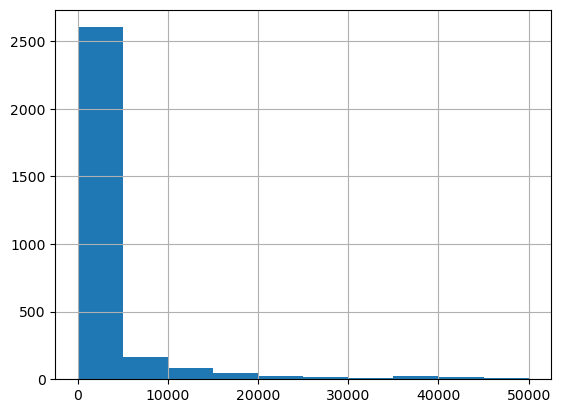

In [22]:
print(map_gdf.MIG_TOT.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
map_gdf.MIG_TOT.hist(range=(0,50000))

## 2.2 Prepare socioeconomic dataframe

In [ ]:
# Filter out columns needed for the socioeconomic pop-up dashboard
mig_cols = ['MIG_TOT', 'MIG_EU', 'MIG_AS', 'MIG_AS_E', 'MIG_AS_SC', 'MIG_AS_SE', 'MIG_AS_W',
            'MIG_AFR',  # 'MIG_AFR_E', 'MIG_AFR_M', 'MIG_AFR_N', 'MIG_AFR_S', 'MIG_AFR_W',
            'MIG_OC', 'MIG_LA', 'MIG_LA_CAR', 'MIG_LA_CAM', 'MIG_LA_CAM_MX', 'MIG_LA_SAM',
            'MIG_NA']
socioec_ECF = totalECF_demo[
    ['FIPS', 'County', 'FIPSTATE', 'State',
     'tonCO2e_eff_avg', 'tonCO2e_eff_peremp_avg', 'tonCO2e_eff_peremp_avg_log10',
     'POP', 'Emp', 'UNEMP_RATE', 'POV_RATE', 'INC_IND_TOT', 'ED_PERCENT_TERTIARY'
     ] + mig_cols
]

# Rename & reformat columns
socioec_ECF['County'] = socioec_ECF['County'].str.capitalize()
socioec_ECF = socioec_ECF.rename(
    columns={
        'County': 'COUNTY',
        'State': 'STATE',
        'tonCO2e_eff_avg': 'TONCO2E',
        'tonCO2e_eff_peremp_avg': 'ECF',
        'tonCO2e_eff_peremp_avg_log10': 'ECF_log10',
        'Emp': 'EMP_TOT'})

# Calculate migrate population percentages percentages
mig_cols.remove('MIG_TOT')
for col in mig_cols:
    socioec_ECF[f'{col}_PERCENT'] = socioec_ECF[col] / socioec_ECF.MIG_TOT * 100
socioec_ECF['MIG_LA_CAM_OTHER_PERCENT'] = socioec_ECF.MIG_LA_CAM_PERCENT - \
    socioec_ECF.MIG_LA_CAM_MX_PERCENT
socioec_ECF = socioec_ECF.drop(columns=mig_cols)

# Pivot sectoral data to give tonCO2e and emp per sector for each county
socioec_ECF_sectoral = sectorECF_demo.pivot(
    index='FIPS',
    columns='sector',
    values=['Emp', 'tonCO2e_eff_avg']
).reset_index()
for sector in sectorECF_demo.sector.unique():
    socioec_ECF_sectoral[f'EMP_{sector}'] = socioec_ECF_sectoral[('Emp', sector)]
    socioec_ECF_sectoral[f'TONCO2E_{sector}'] = socioec_ECF_sectoral[('tonCO2e_eff_avg', sector)]
socioec_ECF_sectoral = socioec_ECF_sectoral.drop(
    columns=['Emp', 'tonCO2e_eff_avg']).droplevel(level=1, axis=1)

# Merge sectoral data onto total county data
socioec_ECF = pd.merge(socioec_ECF, socioec_ECF_sectoral, how='left', on='FIPS')
for sector in sectorECF_demo.sector.unique():
    socioec_ECF[f'EMP_{sector}'] = socioec_ECF.apply(
        lambda x: x[f'EMP_{sector}'] if x[f'EMP_{sector}'] > 0 else
        (x[f'EMP_{sector}'] if x[f'TONCO2E_{sector}'] > 0 else 0),
        axis=1
        )
    socioec_ECF[f'TONCO2E_{sector}'] = socioec_ECF[f'TONCO2E_{sector}'].fillna(0)
    socioec_ECF[f'EMP_{sector.upper()}_PERCENT'] = socioec_ECF[f'EMP_{sector}'] / \
        socioec_ECF.EMP_TOT * 100
    socioec_ECF[f'TONCO2E_{sector.upper()}_PERCENT'] = socioec_ECF[f'TONCO2E_{sector}'] / \
        socioec_ECF.TONCO2E * 100
    socioec_ECF = socioec_ECF.drop(columns=[f'EMP_{sector}', f'TONCO2E_{sector}'])

# Create state and national ECF figures
totalECF_state_demo = totalECF_demo[
    ['FIPSTATE', 'State', 'tonCO2e_eff_avg', 'burden_avg', 'POP', 'Emp']
].groupby(by=['FIPSTATE', 'State'], as_index=False).sum()
totalECF_state_demo['tonCO2e_eff_peremp_avg'] = totalECF_state_demo.tonCO2e_eff_avg / \
    totalECF_state_demo.Emp
totalECF_state_demo['tonCO2e_eff_peremp_avg_log10'] = np.log10(
    totalECF_state_demo['tonCO2e_eff_peremp_avg']
)
mean = np.mean(totalECF_state_demo.tonCO2e_eff_peremp_avg_log10)
std = np.std(totalECF_state_demo.tonCO2e_eff_peremp_avg_log10)
totalECF_state_demo = totalECF_state_demo.rename(
    columns={'tonCO2e_eff_peremp_avg': 'ECF_ST',
             'tonCO2e_eff_peremp_avg_log10': 'ECF_ST_log10'}
)
totalECF_state_demo = totalECF_state_demo[['FIPSTATE', 'ECF_ST', 'ECF_ST_log10']]

totalECF_US = totalECF_demo.tonCO2e_eff_avg.sum() / totalECF_demo.Emp.sum()
totalECF_US_log10 = np.log10(totalECF_US)

# Merge onto total county data
socioec_ECF = pd.merge(socioec_ECF, totalECF_state_demo, how='left', on='FIPSTATE')
socioec_ECF['ECF_US'] = totalECF_US
socioec_ECF['ECF_US_log10'] = totalECF_US_log10


In [ ]:
# Write to CSV
socioec_ECF.to_csv('socioec_ECF.csv')